In [1]:
from gurobipy import Model, GRB, quicksum

In [2]:
#import nbimporter
#from fct_usuelles import lire_graphe, afficher_graphe, visualiser_graphe_par_etape
#from fct_usuelles import generate_cyclic_graph, generate_chain_graph, generate_spider_graph

# Problème **GBP-IP** (Graph Burning Problem - Integer Program) avec **Gurobi**

---

### **Variables du problème :**
- $x_{v, i}$ : une variable binaire qui vaut 1 si le sommet $v \in V$ est le $i$-ème feu dans la séquence de brûlage, et 0 sinon.

---

### **Fonction Objectif :**

La fonction objectif de ce problème est de **minimiser** la valeur de $ z $
$$
\text{Minimiser } z
$$

### **Contraintes :**

1. 
   $$
   i \cdot \sum_{v \in V} x_{v, i} \leq z, \quad \forall i \in \{1, 2, \dots, B\}
   $$

2. **(6)** Chaque sommet $v$ ne peut apparaître **qu'une seule fois** dans la séquence :
   $$
   \sum_{i=1}^B x_{v, i} \leq 1, \quad \forall v \in V
   $$

3. **(7)** À chaque position $i$ dans la séquence (1 à $B$), il doit y avoir **exactement un sommet** assigné :
   $$
   \sum_{v \in V} x_{v, i} = 1, \quad \forall i \in \{1, 2, \dots, B\}
   $$

4. **(8)** Chaque sommet $v$ doit être **couvert** (brûlé) au plus tard à l'étape $B$ :
   $$
   \sum_{i=1}^B \sum_{u \in V : v \in N_{B-i}[u]} x_{u, i} \geq 1, \quad \forall v \in V
   $$
   où $N_{B-i}[u]$ est le voisinage étendu autour du sommet $u$ avec une distance $B-i$.


### **Explications :**
1. **Données d'entrée** :
   - `V` : Liste des sommets du graphe.
   - `B` : Longueur maximale de la séquence.
   - `N` : Dictionnaire représentant les voisins étendus $ N_{B-i}[u] $ pour un sommet $ u $.

2. **Variables** :
   - `x[v, i]` : Variables binaires créées avec `addVars`.

3. **Contraintes** :
   - `(6)` : Chaque sommet $ v $ apparaît au plus une fois.
   - `(7)` : Chaque position $ i $ de la séquence contient exactement un sommet.
   - `(8)` : Chaque sommet $ v $ est "couvert" par au moins un feu à l'étape $ i $.

4. **Optimisation** :
   - La fonction objectif est laissée vide (à compléter selon le problème).

---

### **Résultat attendu :**
Après exécution, le programme affichera quels sommets $ v $ sont brûlés à quelles étapes $ i $.

---

In [3]:
# 10 sommets (3.16)
#fichier = r'instances\Stranke94\Stranke94.mtx'

# 29 sommets (5.38)
#fichier = r'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.mtx'

# 34 sommets (5,83)
#fichier = r'instances\karate\karate.mtx'

# 7057 sommets (84.005)
#fichier = r'instances\fb-pages-government\fb-pages-government.mtx'

# 11631 sommets (107.84)
#fichier = r'instances\web-wiki-crocodile\web-wiki-crocodile.mtx'

# 196 591 sommets (443.38)
#fichier = r'instances\loc-gowalla_edges\loc-gowalla_edges.mtx'

#graphe = lire_graphe(fichier)

In [4]:
# Graphe cyclique
#graphe = generate_cyclic_graph(16)

# Graphe en chaîne
#graphe = generate_chain_graph(16)

# Graphe en étoile (spider)
#graphe = generate_spider_graph(0, leg_length=4, num_legs=5)

In [5]:
#afficher_graphe(graphe)

## Old version

In [6]:
# Fonction pour calculer N_{B-i}[u]
def calculer_voisinage_etendu(graphe, u, distance):
    """
    Calcule la liste des sommets atteignables jusqu'à une certaine distance depuis un sommet donné.
    
    :param graphe: Dictionnaire représentant la liste d'adjacence du graphe.
    :param u: Sommet de départ.
    :param distance: Rayon du voisinage (nombre maximum d'arêtes).
    :return: Liste des sommets atteignables jusqu'à la distance donnée (sans doublons).
    """
    if distance < 1:
        return []

    visites = set()  # Ensemble pour éviter les doublons
    a_explorer = {u}  # Sommets à explorer, initialement le sommet de départ

    for _ in range(distance):
        nouveaux_voisins = set()
        for v in a_explorer:
            # Ajouter les voisins directs du sommet courant
            nouveaux_voisins.update(graphe.get(v, []))
        # Mettre à jour les sommets à explorer avec les nouveaux voisins qui n'ont pas encore été visités
        a_explorer = nouveaux_voisins - visites
        visites.update(nouveaux_voisins)

        # Si aucun sommet n'est à explorer, il n'y a plus de sommets à visiter
        if not a_explorer:
            break

    return list(visites)


relaxation linéarie = x réel appartient à [0, 1]

résoudre le voisinage

tester pour les graphe chemain et graphe arégné et graphe étoile

In [11]:
def solver(graphe):
    # Paramètres du modèle
    V = list(graphe.keys())  # Sommets du graphe
    B = round(len(V) ** 0.5)  # Longueur maximale de la séquence de brûlage

    # Création du modèle
    model = Model("GBP-IP")

    # Variables : x[v, i] pour chaque sommet v et étape i
    x = model.addVars(V, range(1, B+1), vtype=GRB.BINARY, name="x")

    # Variable pour minimiser b
    z = model.addVar(vtype=GRB.CONTINUOUS, name="z")

    # Contrainte (6) : Chaque sommet apparaît au plus une fois dans la séquence
    for v in V:
        model.addConstr(quicksum(x[v, i] for i in range(1, B+1)) <= 1, f"once_{v}")

    # Contrainte (7) : Chaque position i de la séquence a exactement un sommet
    for i in range(1, B+1):
        model.addConstr(quicksum(x[v, i] for v in V) == 1, f"position_{i}")

    # Contrainte (8) : Chaque sommet doit être brûlé au plus tard à l'étape B
    for v in V:
        model.addConstr(quicksum(
            quicksum(x[u, i] for u in V if v in calculer_voisinage_etendu(graphe, u, B-i))  # Voisins pouvant brûler v
            for i in range(1, B+1)
        ) >= 1, f"cover_{v}")

    # Contrainte (9) : i * \sum_{v \in V} x[v, i] <= b, \forall i \in {1, ..., B}
    for i in range(1, B+1):
        model.addConstr(i * quicksum(x[v, i] for v in V) <= z, f"minimize_z_{i}")

    # Fonction objectif : Minimiser b
    model.setObjective(z, GRB.MINIMIZE)

    model.setParam("OutputFlag", 0)  # Désactiver les logs

    # Résolution du modèle
    model.optimize()
    # Affichage des résultats
    if model.status == GRB.OPTIMAL:
        print("Solution optimale trouvée :")
        chemin = []  # Liste pour enregistrer les sommets brûlés à chaque étape
        for i in range(1, B+1):
            for v in V:
                if x[v, i].x > 0.5:  # Vérifier si x[v, i] est actif
                    chemin.append(v)  # Ajouter le sommet et l'étape au chemin
                    #print(f"Le sommet {v} est brûlé à l'étape {i}")
        
        print("Chemin trouvé :", chemin)  # Afficher la séquence complète des sommets brûlés
        return chemin
    #else:
    #    print("Pas de solution optimale trouvée.")

In [12]:
#solver(graphe)

Solution optimale trouvée :
Chemin trouvé : [4, 5, 1]


La modélisation présente quelques problèmes clés à corriger, notamment concernant la fonction objectif et l'utilisation de `B`. Voici les points essentiels :

### **Problèmes identifiés :**
1. **Fonction objectif redondante** :  
   La variable `z` est forcée d'être égale à `B` à cause des contraintes (1) et (7). En effet :  
   - La contrainte (7) impose qu'à chaque étape `i`, un sommet est choisi (`sum x[v,i] = 1`).  
   - La contrainte (1) donne `i * 1 ≤ z` pour tout `i`, donc `z ≥ B`.  
   Minimiser `z` revient donc à fixer `z = B`, ce qui rend l'objectif inutile.

2. **Paramètre `B` mal défini** :  
   `B` est actuellement fixé à `round(len(V)**0.5)`, ce qui n'est pas nécessairement optimal. Le véritable objectif devrait être de **minimiser `B`** (le nombre d'étapes pour brûler le graphe), mais `B` est traité comme une constante ici.

## New version

In [13]:
def solveur_gbp(graphe, B_max):
    for B in range(1, B_max + 1):
        model = Model("GBP-IP")
        V = list(graphe.keys())
        x = model.addVars(V, range(1, B+1), vtype=GRB.BINARY, name="x")

        # Contrainte (6)
        for v in V:
            model.addConstr(quicksum(x[v, i] for i in range(1, B+1)) <= 1, f"once_{v}")

        # Contrainte (7)
        for i in range(1, B+1):
            model.addConstr(quicksum(x[v, i] for v in V) == 1, f"position_{i}")

        # Contrainte (8)
        for v in V:
            model.addConstr(
                quicksum(
                    x[u, i] 
                    for i in range(1, B+1) 
                    for u in V 
                    if v in calculer_voisinage_etendu(graphe, u, B - i)
                ) >= 1, 
                f"cover_{v}"
            )

        model.setParam("OutputFlag", 0)  # Désactiver les logs
        model.optimize()
        
        # Affichage des résultats
        if model.status == GRB.OPTIMAL:
            print(f"Solution trouvée pour B = {B}")
            chemin = []  # Liste pour enregistrer les sommets brûlés à chaque étape
            for i in range(1, B+1):
                for v in V:
                    if x[v, i].x > 0.5:  # Vérifier si x[v, i] est actif
                        chemin.append(v)  # Ajouter le sommet et l'étape au chemin
            
            print("Chemin trouvé :", chemin)  # Afficher la séquence complète des sommets brûlés
            return B, chemin  # Retourner la solution optimale
    return None, None

In [ ]:
#B_max = round(len(graphe)**0.5)
#B, chemin = solveur_gbp(graphe, B_max)

Solution trouvée pour B = 3
Chemin trouvé : [4, 5, 1]


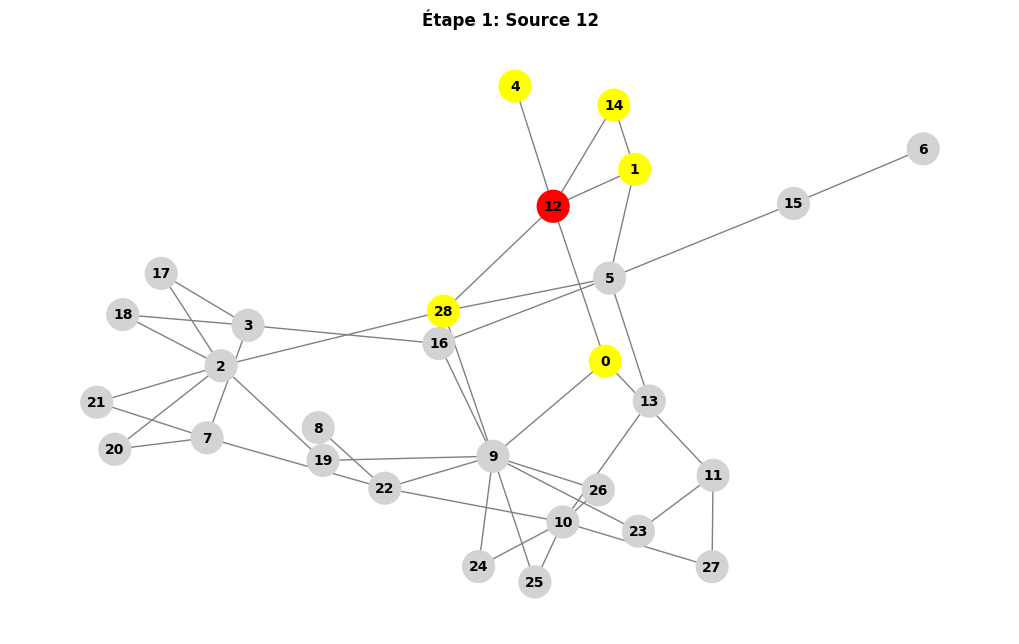

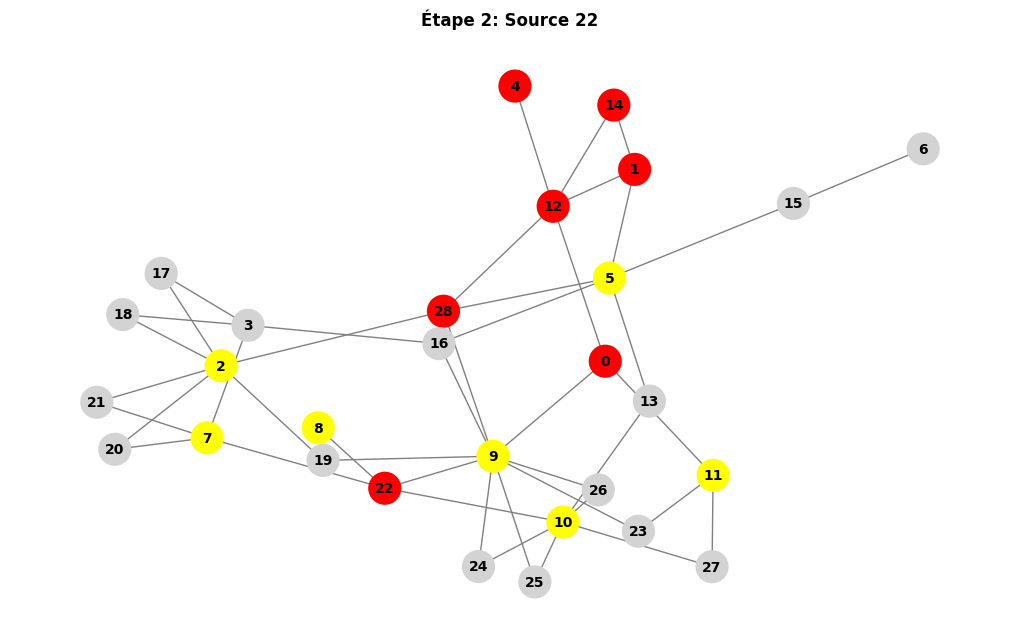

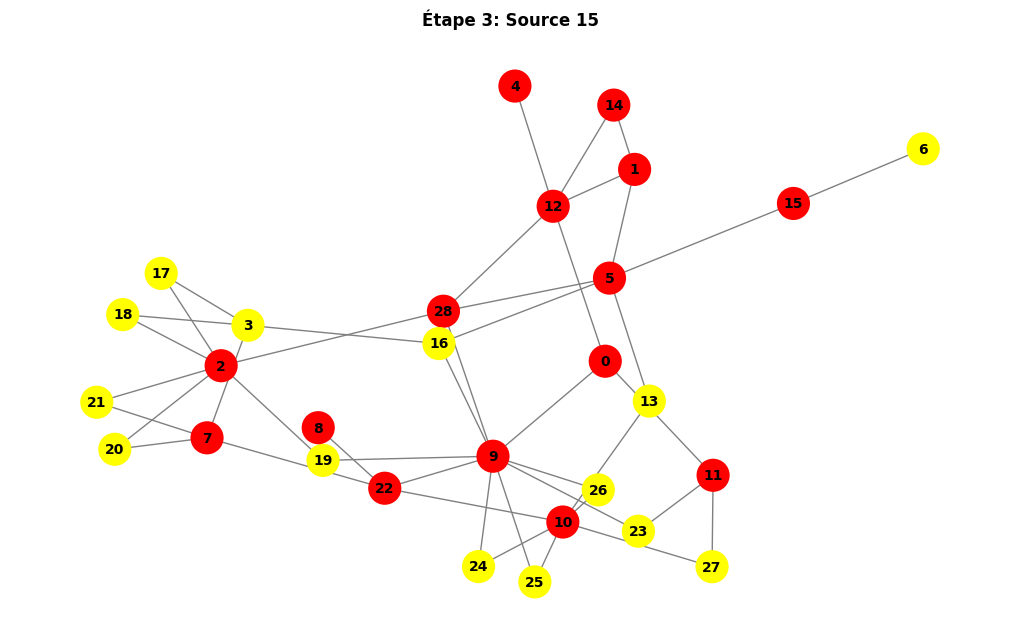

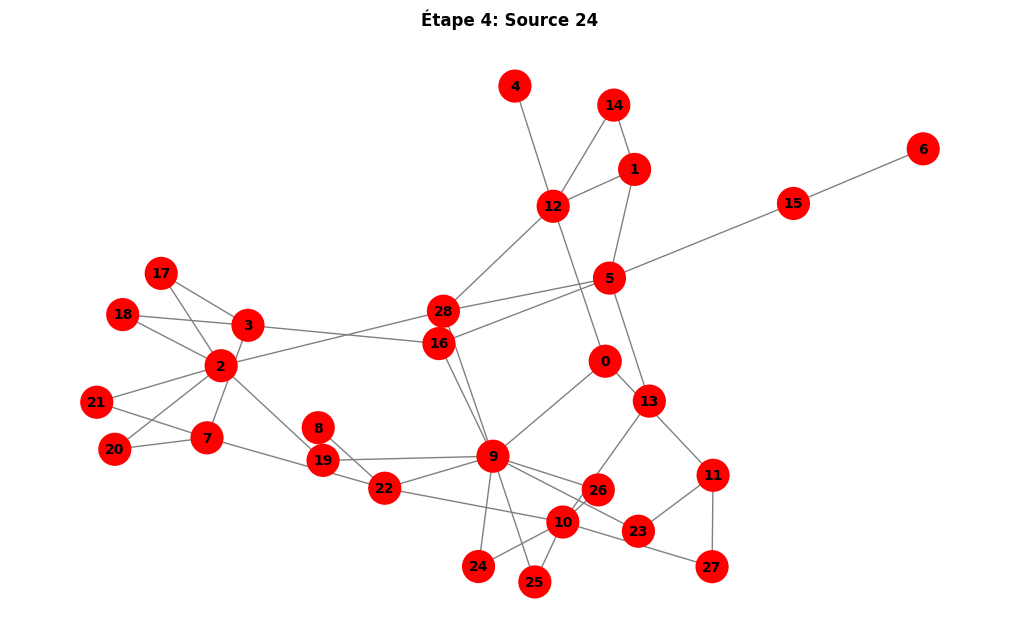

In [78]:
# Visualiser le graphe par étape
#visualiser_graphe_par_etape(graphe, chemin)